# Exponential Smoothing Model (ETS and AutoETS)

The **ETS** (Error, Trend, Seasonality) framework is a powerful and flexible approach to **exponential smoothing** for time series forecasting. ETS models are characterized by three key components: the type of **error** (additive or multiplicative), the type of **trend** (none, additive, multiplicative, or damped), and the type of **seasonality** (none, additive, or multiplicative). This systematic framework provides a **unified approach** to exponential smoothing methods, encompassing classic techniques like **simple exponential smoothing**, **Holt's linear method**, and **Holt-Winters seasonal methods**.

Unlike models that rely on differencing transformations to achieve stationarity, ETS uses a **state-space formulation** where the level, trend, and seasonal components are **recursively updated** at each time step. This makes ETS models **highly interpretable** while maintaining flexibility to handle various patterns in time series data.

**The ETS Framework**

ETS models maintain internal state variables that evolve over time through smoothing equations:

* **Level ($\ell_t$)**: The baseline value of the series at time $t$.
* **Trend ($b_t$)**: The rate of change or growth pattern.
* **Seasonal ($s_t$)**: Repeating patterns with a fixed period $m$.

Each component can be modeled as additive or multiplicative, resulting in different model behaviors.

**Error, Trend, and Seasonality Components**

The model specification uses three-letter notation (e.g., "AAN", "MAM"):

**First Letter - Error Type:**
* **A (Additive)**: Errors are independent of the series level
* **M (Multiplicative)**: Errors scale proportionally with the series level

**Second Letter - Trend Type:**
* **N (None)**: No trend component
* **A (Additive)**: Linear trend
* **M (Multiplicative)**: Exponential growth trend
* **Add damping**: Use `damped=True` to dampen the trend over time

**Third Letter - Seasonal Type:**
* **N (None)**: No seasonal pattern
* **A (Additive)**: Constant seasonal effect
* **M (Multiplicative)**: Seasonal effect proportional to level


**ETS vs. ARIMA**

While both methods aim to predict future values based on history, they approach the problem from fundamentally different angles.

| Feature | ARIMA (Auto-Regressive Integrated Moving Average) | ETS (Error, Trend, Seasonality) |
| :--- | :--- | :--- |
| **Approach** | **Differencing + ARMA.** Achieves stationarity through differencing, then fits AR and MA terms. | **State-Space Smoothing.** Recursively updates level, trend, and seasonal states with exponential smoothing. |
| **Model Form** | **Linear combination of past values and errors** (after differencing). | **Explicit state equations** for level, trend, and seasonality with additive or multiplicative structure. |
| **Automation** | **Configurable.** Requires selecting orders ($p, d, q$), though auto-selection methods (AIC, BIC) can assist. | **Fully Automated.** Model selection ('ZZZ') systematically searches over all valid ETS models. |



<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:600;">
  <span style="margin-right:6px; font-size:22px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0; color:inherit;">
  
The Python implementation of the ETS algorithm in skforecast is based on the Julia package <a href="https://taf-society.github.io/Durbyn.jl/dev/">Durbyn.jl</a> developed by Resul Akay. For more details on the mathematical formulation and estimation procedures, visit the <a href="https://cienciadedatos.net/documentos/py76-exponential-smoothing-models.html">Exponential Smoothing Model</a>.
</p>

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import sys
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.stats import Ets
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme, plot_prediction_intervals
from skforecast.utils import expand_index
from sklearn.metrics import mean_absolute_error
set_dark_theme()

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=False)
data = data.loc[:'1990-01-01 00:00:00', ['Gasolinas']]
data = data.rename(columns={'Gasolinas': 'y'})
data.index.name = 'datetime'
data.head(4)

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 5 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y
datetime,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164


Train dates : 1969-01-01 00:00:00 --- 1983-01-01 00:00:00  (n=169)
Test dates  : 1983-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=84)


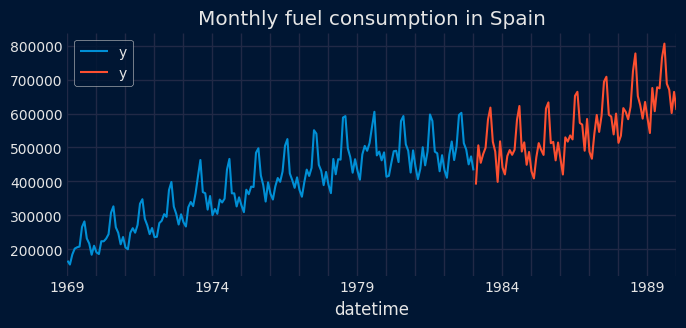

In [3]:
# Split data in train-test partitions
# ======================================================================================
end_train = '1983-01-01 23:59:59'

print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)

data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

## ETS

**Skforecast** provides the class [`Ets`](../api/stats.html#skforecast.stats._ets.Ets) to facilitate the creation of ETS models in Python, allowing users to easily fit and forecast time series data using this approach.

The `Ets` class provides flexible control over model specification and parameter estimation through several key arguments:

**Model Specification**

* `model`: Three-letter code specifying the model structure:
  * First letter (Error): `A` (Additive), `M` (Multiplicative), or `Z` (Auto-select)
  * Second letter (Trend): `N` (None), `A` (Additive), `M` (Multiplicative), or `Z` (Auto-select)
  * Third letter (Season): `N` (None), `A` (Additive), `M` (Multiplicative), or `Z` (Auto-select)
  * Examples: `"ANN"` (simple exponential smoothing), `"AAN"` (Holt's linear trend), `"AAA"` (additive Holt-Winters)
  * Use `"ZZZ"` for fully automatic model selection

* `m`: Seasonal period (e.g., 12 for monthly data with yearly seasonality, 4 for quarterly)

* `damped`: Enable damped trend to prevent unbounded extrapolation
  * `True`: Use damped trend
  * `False`: Use standard (non-damped) trend
  * `None`: Try both when `model="ZZZ"` (automatic selection)

**Fixed Parameters (optional)**

If specified, these parameters are held fixed instead of being estimated:

* `alpha`: Level smoothing parameter (0 < α < 1)
* `beta`: Trend smoothing parameter (0 < β < α)
* `gamma`: Seasonal smoothing parameter (0 < γ < 1-α)
* `phi`: Damping parameter (0 < φ < 1)

**Automatic Model Selection (model="ZZZ")**

* `seasonal`: Allow seasonal models in automatic selection
* `trend`: Control trend in model search
  * `None`: Try both trending and non-trending models
  * `True`: Only try models with trend
  * `False`: Only try models without trend
* `ic`: Information criterion for model selection
  * `"aic"`: Akaike Information Criterion
  * `"aicc"`: Corrected AIC (recommended for small samples)
  * `"bic"`: Bayesian Information Criterion
* `allow_multiplicative`: Allow multiplicative errors and seasonality
* `allow_multiplicative_trend`: Allow multiplicative trend (generally not recommended)

**Transformations**

* `lambda_param`: Box-Cox transformation parameter
  * `None`: No transformation
  * `0`: Log transformation
  * `1`: No transformation
  * Other values: Box-Cox transformation
* `lambda_auto`: Automatically select optimal Box-Cox parameter
* `bias_adjust`: Apply bias adjustment when back-transforming forecasts

**Parameter Constraints**

* `bounds`: Type of parameter bounds
  * `"usual"`: Traditional bounds (0 < α, β*, γ < 1)
  * `"admissible"`: Broader stability bounds (e.g., 0 < α < 2 for ANN)
  * `"both"`: Check both usual and admissible bounds

**Common Configuration Examples**

| Use Case | Configuration | Description |
|:---------|:--------------|:------------|
| Automatic (unrestricted) | `Ets(m=12, model="ZZZ")` | Fully automatic selection from all valid models |
| Automatic (conservative) | `Ets(m=12, model="ZZZ", allow_multiplicative=False)` | Only additive error and seasonality models |
| Simple exponential smoothing | `Ets(model="ANN")` | No trend, no seasonality (flat forecast) |
| Holt's linear trend | `Ets(model="AAN")` | Additive trend, no seasonality |
| Damped trend | `Ets(model="AAN", damped=True)` | Dampened trend for conservative long-term forecasts |
| Additive Holt-Winters | `Ets(model="AAA", m=12)` | Additive trend and seasonality |
| Multiplicative Holt-Winters | `Ets(model="MAM", m=12)` | Multiplicative errors, additive trend, multiplicative seasonality |
| Seasonal no trend | `Ets(model="ANA", m=12)` | Additive seasonality without trend |
| Non-seasonal with Box-Cox | `Ets(model="AAN", lambda_auto=True)` | Automatic variance stabilization transformation |
| Fixed smoothing parameters | `Ets(model="AAN", alpha=0.2, beta=0.1)` | Manual parameter specification (not estimated) |

In [4]:
# ETS with a specific model configuration
# ==============================================================================
model = Ets(m=12, model="AAA")
model.fit(y=data_train['y'])
model.summary()

ETS Model Summary
Model: Ets(AAA)
Seasonal period (m): 12

Smoothing parameters:
  alpha (level):       0.1000
  beta (trend):        0.0100
  gamma (seasonal):    0.0100

Initial states:
  Level (l0):          197637.6942
  Trend (b0):          2251.9201

Model fit statistics:
  sigma^2:             294326220.344355
  Log-likelihood:      -1639.36
  AIC:                 3312.72
  BIC:                 3365.93

Residual statistics:
  Mean:                -1152.867362
  Std Dev:             16331.260792
  MAE:                 12418.719387
  RMSE:                16323.633666

Time Series Summary Statistics:
Number of observations: 169
  Mean:                 384743.1773
  Std Dev:              108126.6689
  Min:                  155466.8105
  25%:                  303667.7591
  Median:               397278.0241
  75%:                  466194.3073
  Max:                  605073.0143


## AutoETS

When `model` is set to "ZZZ" or `None`, the `ETS` class performs automatic model selection following this process:

1. **Candidate Model Generation**: Constructs a set of candidate models by combining different error types (A/M), trend types (N/A/M), and seasonal types (N/A/M), subject to constraints:
   - By default, multiplicative trend is excluded (`allow_multiplicative_trend=False`) as it can be numerically unstable
   - Certain combinations are invalid (e.g., additive error with multiplicative components)
   - If data has fewer observations than the seasonal period `m`, only non-seasonal models are considered
   - For high-frequency data (`m > 24`), seasonality is automatically disabled

2. **Model Estimation**: Each candidate model is fitted to the data using maximum likelihood estimation with parameter bounds checking (`bounds="both"` by default, ensuring both usual and admissible constraints)

3. **Model Evaluation**: Models are ranked using the specified information criterion:
   - **AICc** (default): Corrected AIC, recommended for small samples: $\text{AICc} = \text{AIC} + \frac{2k(k+1)}{n-k-1}$
   - **AIC**: Akaike Information Criterion: $\text{AIC} = -2\log L + 2k$
   - **BIC**: Bayesian Information Criterion: $\text{BIC} = -2\log L + k\log n$

4. **Best Model Selection**: Returns the model with the lowest information criterion value. If the data shows evidence of trend (>10% change between first and second half), models without trend receive a penalty to prefer trending models.

The `trend`, `seasonal`, `damped`, and `allow_multiplicative` parameters control which candidate models are considered, allowing you to restrict the search space based on domain knowledge.

<div role="note"
    style="background: rgba(0,191,191,.08); border-left: 6px solid #00bfa5;
        border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00bfa5;
        margin:0 0 6px 0; font-weight:600;">
<span style="margin-right:6px; font-size:18px;">💡</span>
<strong style="margin-right:6px; font-size:18px;">Tip</strong>
</p>

<p style="margin:0; color:inherit;">
    The implementation of ETS in skforecast uses numba to optimize performance. Because the first call to <code>fit()</code> or <code>predict()</code> triggers code compilation, it may take longer than subsequent calls. After this initial compilation, performance improves significantly. While this overhead can feel inconvenient during interactive sessions, it provides substantial benefits in production environments, where thousands of models may be fitted and forecasted efficiently.
  </p>

</div>

In [5]:
# AutoETS: automatic model selection
# ==============================================================================
model = Ets(m=12, model=None)
model.fit(y=data_train['y'])
model.summary()

ETS Model Summary
Model: Ets(MAM)
Seasonal period (m): 12

Smoothing parameters:
  alpha (level):       0.1000
  beta (trend):        0.0100
  gamma (seasonal):    0.0100

Initial states:
  Level (l0):          191275.6996
  Trend (b0):          2678.3040

Model fit statistics:
  sigma^2:             0.001604
  Log-likelihood:      -1614.33
  AIC:                 3262.66
  BIC:                 3315.87

Residual statistics:
  Mean:                -1587.582913
  Std Dev:             16096.366173
  MAE:                 11681.267343
  RMSE:                16127.006194

Time Series Summary Statistics:
Number of observations: 169
  Mean:                 384743.1773
  Std Dev:              108126.6689
  Min:                  155466.8105
  25%:                  303667.7591
  Median:               397278.0241
  75%:                  466194.3073
  Max:                  605073.0143


The automatic model selection identified **ETS(MAM)** as the optimal configuration for this fuel consumption time series. This model combines **multiplicative errors**, **additive trend**, and **multiplicative seasonality** with a 12-month period.

The multiplicative error component indicates that forecast uncertainty scales proportionally with the series level, which is appropriate for data where variability increases over time. The additive trend captures the linear growth pattern in fuel consumption (approximately 2,677 units per month based on the initial trend estimate). Most notably, the multiplicative seasonal component accounts for proportional seasonal variations—meaning that seasonal peaks and troughs grow larger as the overall consumption level increases. This is typical in economic and consumption data where seasonal effects compound with the underlying level.

The model's relatively low smoothing parameters (α=0.10, β=0.01, γ=0.01) suggest that recent observations have moderate influence on the forecasts, with the model relying heavily on the established patterns rather than reacting strongly to recent fluctuations.

## Prediction

Once the model is fitted, it can be used to **forecast future observations**. It is important to note that these types of models require predictions to **follow immediately after the training data**; therefore, the forecast starts right after the **last observed value**.

In [6]:
# Prediction
# ==============================================================================
steps = len(data_test)
predictions = model.predict(steps=steps)

For performance reasons, predictions are returned as **NumPy arrays**. These can be easily converted into **Pandas Series** by mapping them to the corresponding **time index**.

In [7]:
# Predictions as pandas Series
# ==============================================================================
pred_index = expand_index(index=data_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(4)

1983-02-01    408101.282195
1983-03-01    468889.543146
1983-04-01    490033.012053
1983-05-01    482048.495783
Freq: MS, dtype: float64

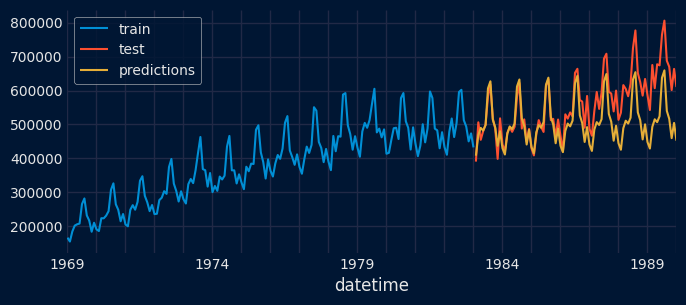

In [8]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
# Prediction error
# ==============================================================================
error_mae = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mae): {error_mae}")

Test error (mae): 58549.300730412826


## Prediction intervals

The method `predict_interval` enables the calculation of **prediction intervals** for the forecasted values. Users can specify the **confidence level** of the estimated interval using the `level` argument.

In [10]:
# Prediction interval
# ==============================================================================
predictions = model.predict_interval(steps=steps, level=[95])
predictions.index = pred_index
predictions.head(3)

,mean,lower_95,upper_95
1983-02-01,408101.282195,375003.711690,438098.338935
1983-03-01,468889.543146,431834.224053,505479.378162
1983-04-01,490033.012053,448440.906850,528809.573343


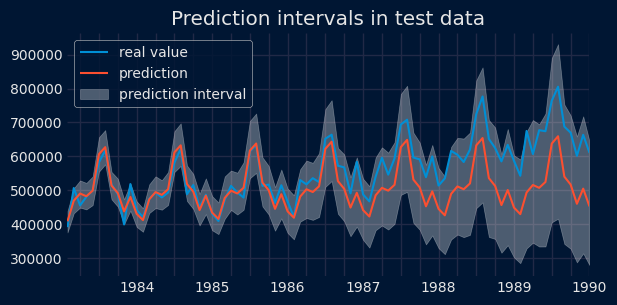

In [11]:
# Plot prediction intervals
# ==============================================================================
preds_to_plot = predictions.copy()
preds_to_plot = preds_to_plot.rename(
    columns={'mean': 'pred', 'lower_95': 'lower_bound', 'upper_95': 'upper_bound'}
)

fig, ax = plt.subplots(figsize=(6, 3))
plot_prediction_intervals(
    predictions         = preds_to_plot,
    y_true              = data_test,
    target_variable     = "y",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'white', 'alpha': 0.3, 'zorder': 1},
    ax                  = ax
)

## Feature importances

The method `get_feature_importances` returns the coefficients of the model, which can be used as a measure of feature importance.

In [12]:
# Feature importances
# ==============================================================================
model.get_feature_importances()

,feature,importance
0,alpha (level),0.10
1,beta (trend),0.01
2,gamma (seasonal),0.01


## Exogenous variables

The addition of **exogenous variables** is done using the `exog` argument. The only requirement for including an exogenous variable is the need to know the **value of the variable** also during the **forecast period**.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables and how to correctly manage them with skforecast visit: <a href="../user_guides/exogenous-variables.html">Exogenous variables (features) user guide</a>.

</div>

In [13]:
# Create calendar features to be used as exogenous variables
# ==============================================================================
data_exog = data.assign(month=data.index.month)
data_exog_train = data_exog.loc[:end_train]
data_exog_test  = data_exog.loc[end_train:]
data_exog.head()

,y,month
datetime,,
1969-01-01,166875.2129,1
1969-02-01,155466.8105,2
1969-03-01,184983.6699,3
1969-04-01,202319.8164,4
1969-05-01,206259.1523,5


In [14]:
# Create and fit model with exogenous variables
# ==============================================================================
model = Ets(m=12, model='MAM')
model.fit(y= data_exog_train['y'], exog=data_exog_train['month'])

# Predict with exog
# ==============================================================================
predictions = model.predict(steps=steps, exog=data_exog_test['month'])
pred_index = expand_index(index=data_train.index, steps=steps)
predictions = pd.Series(predictions, index=pred_index)
predictions.head(3)

1983-02-01    408101.282195
1983-03-01    468889.543146
1983-04-01    490033.012053
Freq: MS, dtype: float64

## Prediction on training data (In-sample Predictions)

Predictions on the training data are crucial for **evaluating the accuracy** and effectiveness of the model. By comparing the **predicted values** with the **actual observed values** in the training dataset, you can assess how well the model has learned the underlying patterns and trends in the data. This comparison helps in understanding the model's performance and identify areas where it may need improvement or adjustment. In essence, they act as a mirror, reflecting how the model interprets and reconstructs the **historical data** on which it was trained.

Predictions of the observations used to fit the model are stored in the `fitted_values_` attribute of the `ETS` object.

In [15]:
# In-sample Predictions
# ==============================================================================
# Show only the first 5 values 
model.fitted_values_[:5]

array([167998.14060777, 162819.56599272, 188519.55126091, 199042.32235291,
       198515.09912727])

## Backtesting

In time series forecasting, the process of [backtesting](./backtesting.html) consists of **evaluating the performance** of a predictive model by applying it **retrospectively to historical data**. To utilize the backtesting functionalities offered by skforecast with ETS models, the model must be used as an **estimator** within a [`ForecasterStats`](./forecasting-statistical-models.html) object.

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:400;">
  <span style="margin-right:6px; font-size:18px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0 ; color:inherit;">
<b>Why do statistical models require refitting during backtesting?</b>
</p>

<p>
Unlike machine learning models, statistical models like ETS maintain an internal state that depends on the sequence of observations. They can only generate predictions starting from the last observed time step — they cannot "jump" to an arbitrary point in the future without knowing all previous values.

During backtesting, when the validation window moves forward, the model must be refitted to incorporate the new observations and update its internal state. This is why <code>refit=True</code> is typically required.

<b>Performance optimization:</b> Because refitting is mandatory, skforecast's Numba-optimized backend becomes essential. It enables hundreds of refits during backtesting in a fraction of the time required by non-optimized libraries.
</p>

</div>

In [16]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterStats(estimator=Ets(m=12, model='MAM'))
forecaster

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Ets'] 
Series name: None 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Estimator parameters: 
    skforecast.Ets: 
        {'m': 12, 'model': 'MAM', 'damped': None, 'alpha': None, 'beta': None,
        'gamma': None, 'phi': None, 'seasonal': True, 'trend': None,
        'allow_multiplicative': True, 'allow_multiplicative_trend': False} 
fit_kwargs: None 
Creation date: 2026-01-31 20:37:34 
Last fit date: None 
Index seen by the forecaster: None 
Skforecast version: 0.20.0 
Python version: 3.13.11 
Forecaster id: None

In [17]:
# Backtest forecaster
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 12,  # predict 12 month per fold
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_stats(
                          forecaster        = forecaster,
                          y                 = data['y'],
                          cv                = cv,
                          metric            = 'mean_absolute_error',
                          n_jobs            = 'auto',
                          suppress_warnings = True,
                          verbose           = True,
                          show_progress     = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 169
Number of observations used for backtesting: 84
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 -- 1985-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1985-01-01 00:00:00  (n=193)
    Validation: 1985-02-01 00:00:00 -- 1986-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1986-01-01 00:00:00  (n=205)
    Validation: 1986-02-01 00:00:00 -- 1987-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1987-01-01 00:00:00  (n=217)
    Validation: 1987-02-0

  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
# Backtesting predictions
# ==============================================================================
predictions.head(3)

,fold,pred
1983-02-01,0,408101.282195
1983-03-01,0,468889.543146
1983-04-01,0,490033.012053


In [19]:
# Backtesting metrics
# ==============================================================================
metric

,mean_absolute_error
0,17742.769329


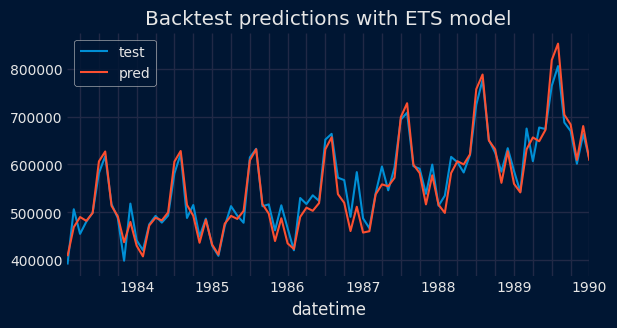

In [20]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax)
ax.set_title('Backtest predictions with ETS model')
ax.legend();

## Memory optimization

For **production environments** where you need to store many fitted models but only require **forecasting capabilities** (not diagnostics), you can significantly **reduce memory usage** with the `reduce_memory()` method. This is especially useful when working with **large datasets** or deploying models in **resource-constrained environments**. This method removes **in-sample fitted values** and **residuals**, which are only needed for diagnostic purposes but not for generating forecasts.

In [21]:
# Compare size before and after reduce_memory()
# ==============================================================================
def total_model_size(model):
    size = sys.getsizeof(model)
    for attr_name in dir(model):
        if attr_name.startswith('_'):
            continue
        try:
            attr = getattr(model, attr_name)
            size += sys.getsizeof(attr)
        except Exception:
            pass
    return size


model = Ets(m=12, model="MAM")
model.fit(y=data_train['y'])
model_size_before = total_model_size(model)
print(f"Memory before reduce_memory(): {model_size_before / 1024:.3f} KB")

# Reduce memory
model.reduce_memory()
model_size_after = total_model_size(model)
print(f"Memory after reduce_memory(): {model_size_after / 1024:.3f} KB")
print(f"Memory reduction: {(1 - model_size_after / model_size_before) * 100:.1f}%")

Memory before reduce_memory(): 5.241 KB
Memory after reduce_memory(): 2.319 KB
Memory reduction: 55.7%


In [22]:
# Predictions still work after memory reduction
# ==============================================================================
model.predict(steps=10)

array([408101.28219452, 468889.54314593, 490033.0120529 , 482048.49578309,
       498540.83005285, 606376.32023292, 627071.55558293, 513633.20160401,
       491399.44856638, 437351.69303856])